# Mining Massive Datasets: Solutions to Problem Set 3

Duc Anh, Phi 3550091

Mustafa, Ibrahim 3284705

Amritpal, Kaur 3532964

## Exercise 1

### a)


In [118]:
import numpy as np

util_matrix = np.array([[4,5,0,5,1,0,3,2], [0,3,4,3,1,2,1,0],[2,0,1,3,0,4,5,3],[1,0,1,0,4,0,4,2]])

def avg_without_blank(x):
    n = np.count_nonzero(x)
    return np.sum(x)/n

def pearson_sim(x,y):
    x_b = x.astype(bool).astype(int)
    y_b = y.astype(bool).astype(int)
    indeces = np.nonzero(np.bitwise_and(x_b, y_b))
    x_centered = x-avg_without_blank(x)
    y_centered = y-avg_without_blank(y)
    x_reduced = x_centered[indeces]
    y_reduced = y_centered[indeces]
    
    res = np.dot(x_reduced, y_reduced) / (np.linalg.norm(x_reduced)*np.linalg.norm(y_reduced))
    return res

def rating(util_matrix, N, item, user):
    similarities = []
    for i in range(util_matrix.shape[0]):
        if i != user:
            similarities.append(pearson_sim(util_matrix[user], util_matrix[i]))
        else:
            similarities.append(-2)
    
    similarities = np.array(similarities)
    
    most_similar = similarities.argsort()[::-1][:N]
    
    numer = 0
    denom = 0
    for i in range(N):
        sim_user_i = similarities[most_similar[i]]
        numer += sim_user_i*util_matrix[most_similar[i]][item]
        denom += sim_user_i
    rating = numer/denom
    return rating

N = 2
item = 4
user = 2

print("predicted rating for item e: ", rating(util_matrix, N, item, user))

predicted rating for item e:  5.140960958442029


### b)

In [2]:
util_matrix = util_matrix.T
N = 2
item = 2
user = 4

print("predicted rating for item e: ", rating(util_matrix, N, item, user))

predicted rating for item e:  4.406435469853564


## Exercise 2

We first implement the Stochastic Gradient Descent (SGD) method:

In [3]:
def gradient_Q_i(d, x_i, y_i, w):
    res = np.zeros(d)
    for k in range(d):
        for j in range(d):
            res[k] += w[j]*(x_i**j)
        res[k] = 2*(res[k]-y_i)*(x_i**k)
    return res

def Q_i(d, x_i, y_i, w):
    res = 0
    for j in range(d):
        res += w[j]*(x_i**j)
    res = (res-y_i)**2
    return res
        
def Q(d, points, w):
    res = 0
    for point in points:
        res += Q_i(d, point[0], point[1], w)
    return res

def SGD(d, points, alpha=0.00001, eps=0.1):
    w = np.random.rand(d)
    while True:
        err_before = Q(d, points, w)
        for point in points:
            w = w - alpha*gradient_Q_i(d, point[0], point[1], w)
        err_after = Q(d, points, w)
        if np.abs(err_before - err_after) < eps:
            break
    return w


Then we define some polynomial, construct slightly perturbed points and run the SGD function on those points:

In [4]:
def poly(x):
    return -1-2*x+x**2+0.5*(x**3)

new_points = []

x_points = np.linspace(-5, 5, 1000)
y_points = poly(x_points)

for i in range(x_points.shape[0]):
    perturbation = np.random.rand()*2-1
    new_points.append((x_points[i], y_points[i]+perturbation))


print(SGD(4, new_points))

[-0.94505448 -1.94480143  0.99607806  0.4955918 ]


The resulting polynomial is within a 0.6 range of the original polynomial.

## Exercise 3
### a)

In [26]:
import findspark
findspark.init('/usr/local/spark')

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.mllib.recommendation import Rating
from pyspark.mllib.recommendation import ALS

spark = SparkSession.builder.master('local').appName('lab3').getOrCreate()
sc = spark.sparkContext

In [103]:
# read the data and convert each row into into Rating object
origRDD = sc.textFile('movielens.txt') \
    .map(lambda line: line.split('\t')) \
    .map(lambda line: Rating(int(line[0]), int(line[1]), float(line[2])))

print(origRDD.count())
origRDD.take(2)

100000


[Rating(user=196, product=242, rating=3.0),
 Rating(user=186, product=302, rating=3.0)]

In [114]:
# split rdd into training and test set
train, test = origRDD.randomSplit(weights=[0.5,0.5], seed=1)

print(train.count(), test.count())

50233 49767


### b)

In [105]:
# initialize model using Alternating Least Squares
model = ALS.train(train, rank=10, iterations=5, seed=1)

# Save model
model.save(sc, "./model")
#model.load(sc, "./model")

### c)

In [115]:
# calculate MSE on test data
test_x = test.map(lambda r: (r.user, r.product))
predictions = model.predictAll(test_x).map(lambda p: ((p.user, p.product), p.rating))
test = test.map(lambda t: ((t.user, t.product), t.rating))
testAndPreds = test.join(predictions)
MSE = testAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("MSE = " + str(MSE))

MSE = 1.4375736550764933


## Exercise 4
### a) We obtain matrices Q and P which are different than the ones shown in the lecture slides.

In [123]:
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
        if e < 0.001:
            break
    return P, Q.T

In [129]:
utMat = np.array([
    [1,0,3,0,0,5,0,0,5,0,4,0],
    [0,0,5,4,0,0,4,0,0,2,1,3],
    [2,4,0,1,2,0,3,0,4,3,5,0],
    [0,2,4,0,5,0,0,4,0,0,2,0],
    [0,0,4,3,4,2,0,0,0,0,2,5],
    [1,0,3,0,3,0,0,2,0,0,4,0]
])

N = len(utMat)
M = len(utMat[0])
K = 3

P = np.random.rand(N,K)
print('P:\n', P)
Q = np.random.rand(M,K)
print('Q:\n', Q)

nP, nQ = matrix_factorization(utMat, P, Q, K)
nR = np.dot(nP, nQ.T)
print('nR:\n', nR)


P:
 [[0.11091278 0.71187049 0.13253212]
 [0.74889095 0.62450055 0.65353997]
 [0.89350557 0.90236574 0.19572736]
 [0.35155659 0.28857588 0.26951684]
 [0.13318358 0.45216833 0.26750008]
 [0.55252758 0.86014777 0.45219843]]
Q:
 [[0.60205859 0.25340645 0.33229609]
 [0.679091   0.83551635 0.97218061]
 [0.64639839 0.98420992 0.35682105]
 [0.95718489 0.62118018 0.62415752]
 [0.29522846 0.32280151 0.06110953]
 [0.43529063 0.04873488 0.01132382]
 [0.81936809 0.44500954 0.41842173]
 [0.32085809 0.73527198 0.7892446 ]
 [0.57892183 0.763422   0.47307164]
 [0.70572096 0.32128762 0.26335349]
 [0.38584615 0.67623224 0.1351337 ]
 [0.7545471  0.80204344 0.78217028]]
nR:
 [[1.03336266 3.46613297 3.03882362 1.69475045 3.39411684 4.85067286
  3.22608792 2.42373919 4.8941546  2.6737914  4.20413884 5.36542442]
 [1.37603079 1.49791081 4.90137375 3.97934499 4.01739445 1.11277354
  3.98070984 3.30404062 3.32860905 1.9837758  1.00944692 3.08697296]
 [1.8260123  3.99374808 2.65568802 0.99543735 1.99190334 5.7261

### b)

In [152]:
import matplotlib.pyplot as plt

def matrix_factorization_with_plot(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    errors = []
    differences = []
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
        if len(errors) != 0:
            differences.append(abs(errors[-1]-e))
        errors.append(e)
        if e < 0.001:
            break
    plt.subplot(2, 1, 1)
    plt.plot(list(range(steps)), errors)
    plt.ylabel('error')
    plt.subplot(2, 1, 2)
    plt.plot(list(range(steps-1)), differences)
    plt.ylabel('difference error before')
    plt.show()
    return P, Q.T

P:
 [[0.22642931 0.67448611 0.44001186]
 [0.14925628 0.34808513 0.24444293]
 [0.21868805 0.52986565 0.05052148]
 [0.00915797 0.12885622 0.61281987]
 [0.17574621 0.13567063 0.29343531]
 [0.74733315 0.63551954 0.59584297]]
Q:
 [[0.84964655 0.26813977 0.99957255]
 [0.10468699 0.47921636 0.88143357]
 [0.23559947 0.68479059 0.19724185]
 [0.80911098 0.04915773 0.91992623]
 [0.55063384 0.07879401 0.53125698]
 [0.40068894 0.15271958 0.44982443]
 [0.07431749 0.34557593 0.92763637]
 [0.97735277 0.35414112 0.96274472]
 [0.61164541 0.75065809 0.65673211]
 [0.44531364 0.2310256  0.35213048]
 [0.27851147 0.40979924 0.54753489]
 [0.81527023 0.92120033 0.34687503]]
4999


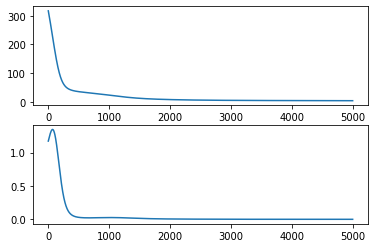

nR:
 [[1.38594229 3.57081048 3.12344882 2.02600901 3.30334452 4.8845462
  3.46069018 2.36638294 4.72076723 3.03933387 4.1993816  4.97877167]
 [0.91211488 1.69205221 4.8278369  4.01884142 5.51800517 2.64389003
  4.00971619 4.56406536 4.22764205 2.00049742 0.99994896 3.04809494]
 [1.47805436 3.99884893 2.01489383 0.95767844 2.00262404 5.36822063
  2.97723716 1.20463296 4.22769592 2.98534472 4.8576183  4.62073404]
 [0.92414489 2.00109706 4.31650573 3.42593806 4.81402013 2.93536059
  3.56881425 3.8666977  4.39020006 2.34284006 1.94488638 4.12056841]
 [0.61334954 1.44976164 3.81460497 2.98848719 4.14860436 2.07192336
  2.6513541  3.28705488 4.08140411 2.28494503 1.99372903 4.93138233]
 [1.18112242 3.12369246 2.85771426 1.84114764 2.9810886  4.23926679
  2.95787867 2.11583102 4.3892357  2.85744763 3.93278786 5.059781  ]]


In [154]:
utMat = np.array([
    [1,0,3,0,0,5,0,0,5,0,4,0],
    [0,0,5,4,0,0,4,0,0,2,1,3],
    [2,4,0,1,2,0,3,0,4,3,5,0],
    [0,2,4,0,5,0,0,4,0,0,2,0],
    [0,0,4,3,4,2,0,0,0,0,2,5],
    [1,0,3,0,3,0,0,2,0,0,4,0]
])

N = len(utMat)
M = len(utMat[0])
K = 3

P = np.random.rand(N,K)
print('P:\n', P)
Q = np.random.rand(M,K)
print('Q:\n', Q)

nP, nQ = matrix_factorization_with_plot(utMat, P, Q, K)
nR = np.dot(nP, nQ.T)
print('nR:\n', nR)